In [349]:
import requests
import numpy as np
import json
import pandas as pd
from datetime import datetime, timedelta
import sklearn
end_date = datetime(2024, 6, 1)
start_date = end_date - timedelta(days=6000)

In [350]:
API_KEY = "wUvM2M29ZVxHDvK8IRp2P7iyrT8uhQG4"

ticker = "AAPL"

url_hist_stock_price = f"https://financialmodelingprep.com/stable/historical-price-eod/light?symbol={ticker}&from={start_date.date()}&to={end_date.date()}&apikey={API_KEY}"

# Historical Data Request
response_hist_stock_price = requests.get(url_hist_stock_price)

json_response_hist_stock_price = response_hist_stock_price.json()

df_stock_hist = pd.DataFrame(json_response_hist_stock_price)

df_stock_hist['date'] = pd.to_datetime(df_stock_hist['date'])
df_stock_hist['price'] = df_stock_hist['price'].astype(float)
df_stock_hist['volume'] = df_stock_hist['volume'].astype(float)


df_stock_hist.set_index('date', inplace=True)
df_stock_hist.drop(columns=['symbol'])

closing_price = df_stock_hist[['price']]
i_volume = df_stock_hist[['volume']]
volume =i_volume.apply(np.log10)

In [351]:
# Daily Return
daily_return = closing_price.pct_change()
# 5-Day Return
ret_5d = closing_price.pct_change(5)
# 10-Day Return
ret_10d = closing_price.pct_change(10)

# 5-Day Volatility (Std Dev of Returns)
vol_5d = closing_price.pct_change().rolling(window=5).std()

# 10-Day Volatility
vol_10d = (closing_price.pct_change().rolling(window=10).std())

# Momentum (10d)
momentum_10d = closing_price - closing_price.shift(10)

# SMA_10/SMA_50 Ratio
sma_10 = closing_price.rolling(window=10).mean()
sma_50 = closing_price.rolling(window=50).mean()
sma_ratio = sma_10/sma_50

# Z-score (20d)
rolling_mean = closing_price.rolling(window=20).mean()
rolling_std = closing_price.rolling(window=20).std()
z_score_20d = (closing_price - rolling_mean)/rolling_std

# RSI (14d)
delta = closing_price.diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain/avg_loss
rsi_14 = 100 - (100 / (1 + rs))

y = closing_price.pct_change(-5)
avrg = y.mean()

y.columns = ['y']


dataframes = [
    (daily_return, 'ret_1d'),
    (ret_5d, 'ret_5d'),
    (ret_10d, 'ret_10d'),
    (vol_5d, 'vol_5d'),
    (vol_10d, 'vol_10d'),
    (momentum_10d, 'momentum_10d'),
    (sma_ratio, 'sma_ratio_10_50'),
    (z_score_20d, 'zscore_20d'),
    (rsi_14, 'rsi_14'),
    (volume,'volume'),
    (y,'y'),
]

df_features_short_term = pd.concat(
    [df.rename(columns={df.columns[0]: name}) for df, name in dataframes],
    axis=1
).dropna()



In [352]:
print(y.max())

y    0.184115
dtype: float64


              ret_1d    ret_5d   ret_10d    vol_5d   vol_10d  momentum_10d  \
date                                                                         
2024-03-21 -0.264441  0.159713  0.482369 -0.176278 -0.828346      0.826274   
2024-03-20  2.872764  1.073797  1.498812  1.164233  0.131928      3.622369   
2024-03-19 -0.868157  1.265116  1.063983  0.940907  0.320969      2.435937   
2024-03-18 -0.796541  0.664690  0.872598  1.198897  0.424365      1.898226   
2024-03-15 -0.333235  0.235432  0.581844  1.220473  0.449023      1.103802   
2024-03-14  0.225892  0.453699  0.446393  1.190560  0.425241      0.732608   
2024-03-13 -0.626593 -1.043650 -0.009663 -1.001753  0.425684     -0.550959   
2024-03-12  0.885702 -0.290379  0.699006 -0.518978  0.273117      1.426428   
2024-03-11 -0.099901  0.016609  0.494393 -0.731696  0.270626      0.864434   
2024-03-08 -0.684511 -0.138742  0.066514 -0.594089  0.308145     -0.332406   
2024-03-07 -0.582281 -0.491201 -0.036272 -0.571078  0.339797    

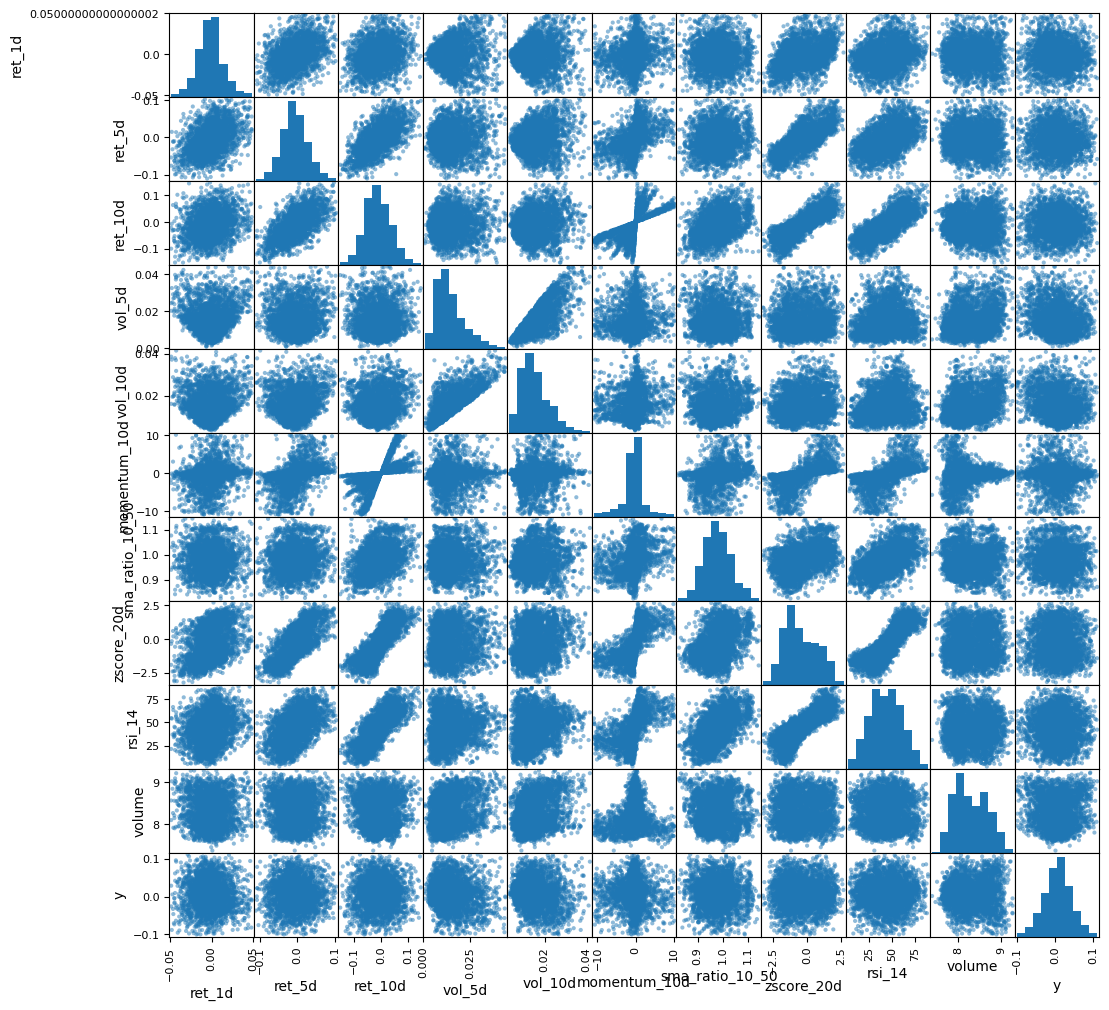

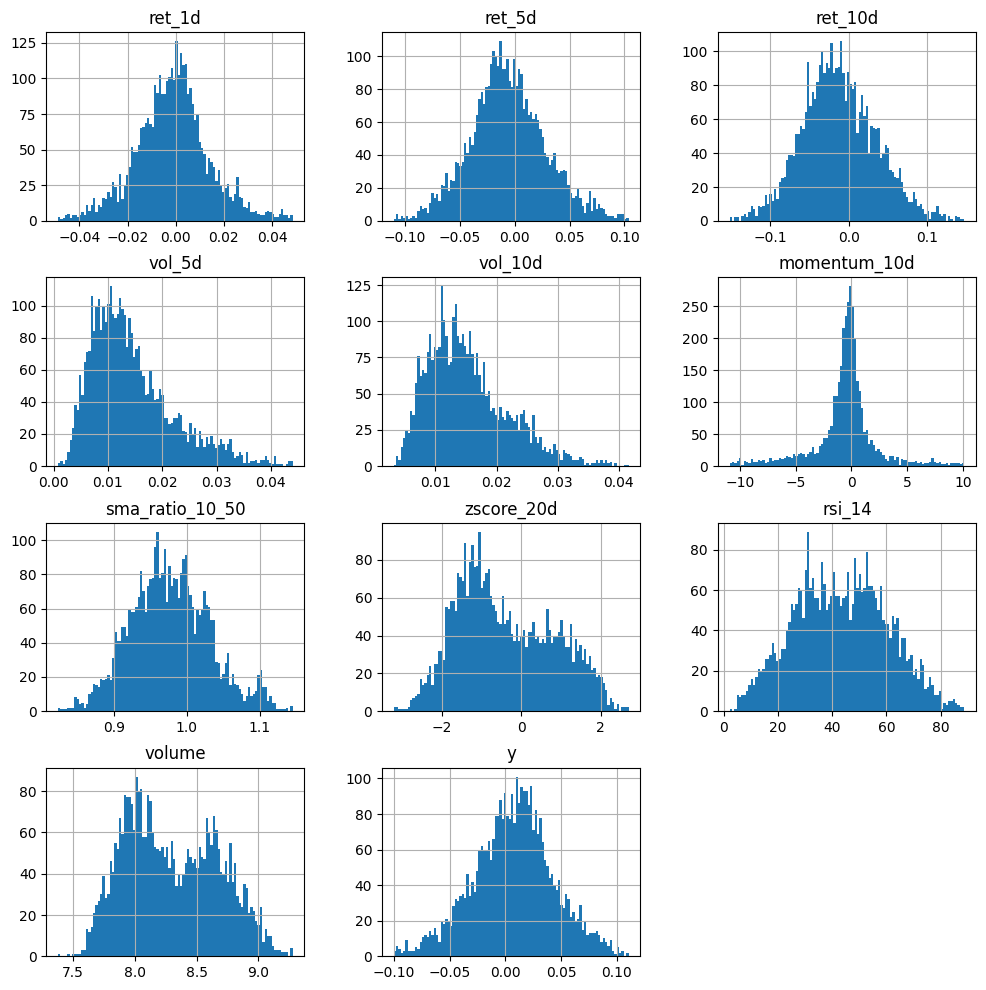

In [353]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Calculate Z-scores for the dataset
z_scores = np.abs(zscore(df_features_short_term))

# Set a threshold for identifying outliers (commonly 3)
threshold = 2.5 # confidence interval of data around 97.6 %.

# Identify rows where any column has a Z-score greater than threshold
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers
df_no_outliers = df_features_short_term[~outliers]


# DATA ANALYSIS

from pandas.plotting import scatter_matrix

scatter_matrix(df_no_outliers, figsize=(12, 12), diagonal='hist')  # or 'kde'
df_no_outliers.hist(figsize=(12, 12), bins=100)

X_data = df_no_outliers.drop(columns=['y'])
y = df_no_outliers['y']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_data)
X_scaled = scaler.transform(X_data)
X = pd.DataFrame(X_scaled, index=X_data.index, columns=X_data.columns)
print(X)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


# Target Columns


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


model = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)

model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)




[0]	validation_0-rmse:0.03560	validation_1-rmse:0.03771
[100]	validation_0-rmse:0.03138	validation_1-rmse:0.03646
[200]	validation_0-rmse:0.02901	validation_1-rmse:0.03599
[300]	validation_0-rmse:0.02738	validation_1-rmse:0.03564
[400]	validation_0-rmse:0.02625	validation_1-rmse:0.03549
[500]	validation_0-rmse:0.02531	validation_1-rmse:0.03542
[588]	validation_0-rmse:0.02421	validation_1-rmse:0.03540
price    7.105396
dtype: float64


<Axes: title={'center': 'Feature Importance'}>

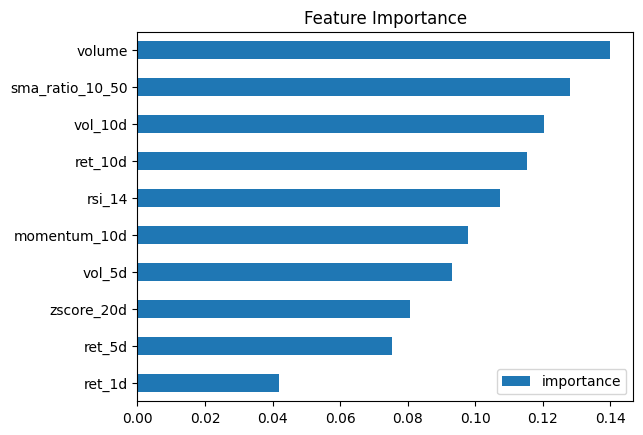

In [355]:
fi = pd.DataFrame(data = model.feature_importances_,index=model.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')


In [356]:
y_pred = model.predict(X_test)
pd.set_option('display.max_rows', None)
result = pd.DataFrame()
result['y'] = y_test
result['y_pred'] = y_pred
print(result)


                   y    y_pred
date                          
2015-12-08  0.007498  0.028261
2022-11-15  0.075556  0.002649
2012-03-15  0.080062 -0.007502
2009-07-02  0.002004  0.012599
2014-03-03  0.000531  0.008712
2019-06-27  0.001404  0.010144
2011-01-10  0.039082  0.011614
2015-08-07 -0.047807 -0.020583
2021-09-20 -0.044199 -0.011038
2017-09-01  0.026020  0.004266
2012-01-23  0.018012  0.003096
2016-10-07  0.009200  0.008156
2017-06-21  0.004960  0.009793
2017-08-10 -0.001543  0.011805
2010-09-30 -0.018411  0.008458
2017-04-28  0.009559  0.011748
2010-08-10 -0.009626 -0.000596
2022-05-12 -0.090642 -0.037350
2010-05-18 -0.016376  0.006726
2012-09-11 -0.021568  0.010288
2013-10-07  0.022901  0.013839
2016-06-10  0.009395 -0.001821
2021-11-18  0.067627  0.011521
2010-10-22 -0.023132  0.008560
2011-07-14  0.001567 -0.003249
2013-07-18  0.010485 -0.002461
2013-03-15  0.027237  0.041865
2016-05-06 -0.011092  0.004776
2016-10-04 -0.000707  0.010189
2019-04-12  0.009543  0.008458
2013-08-